请参考 https://mindspore.cn/mindquantum/docs/zh-CN/master/quantum_approximate_optimization_algorithm.html 完成如下图的MaxCut问题

# 数据

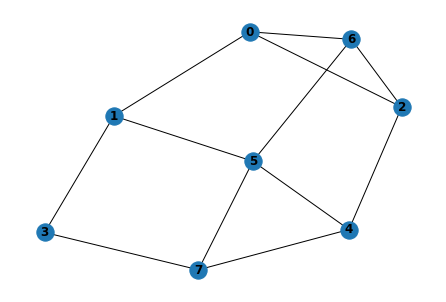

In [9]:
import networkx as nx

g = nx.Graph()
nx.add_path(g, [0, 1])
nx.add_path(g, [0, 2])
nx.add_path(g, [1, 3])
nx.add_path(g, [2, 4])
nx.add_path(g, [4, 5])
nx.add_path(g, [4, 7])
nx.add_path(g, [5, 6])
nx.add_path(g, [6, 2])
nx.add_path(g, [7, 4])
nx.add_path(g, [1, 5])
nx.add_path(g, [0, 6])
nx.add_path(g, [5, 7])
nx.add_path(g, [7, 3])
nx.draw(g, with_labels=True, font_weight='bold')


# 穷举法求解

In [10]:
from itertools import combinations

max_cuts = [[]]
max_cut_size = 0
for i in range(1, g.number_of_nodes()//2+1):  # 一组i个节点、另一组 node number - i 个节点的所有情况
    for cut in combinations(g.nodes(), i):
        cut_size = nx.cut_size(g, cut)
        if cut_size > max_cut_size:
            max_cuts = [cut]
            max_cut_size = cut_size
        elif cut_size == max_cut_size:
            max_cuts.append(cut)
print('max cut size = {}'.format(max_cut_size))
for cut in max_cuts:
    print('{} {}'.format(set(cut), set(g.nodes()).difference(cut)))


max cut size = 10
{0, 2, 3, 5} {1, 4, 6, 7}
{0, 3, 4, 5} {1, 2, 6, 7}
{1, 2, 6, 7} {0, 3, 4, 5}
{1, 4, 6, 7} {0, 2, 3, 5}


# QAOA算法求解

In [11]:
from mindquantum.core import Circuit, Hamiltonian, UN, H, ZZ, RX, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
import networkx as nx
import mindspore.nn as nn


In [12]:
# 量子线路
def build_hc(g, para):
    hc = Circuit()                  # 创建量子线路
    for i in g.edges:
        hc += ZZ(para).on(i)        # 对图中的每条边作用ZZ门
    hc.barrier()                    # 添加Barrier以方便展示线路
    return hc


# 线路展示
circuit = build_hc(g, 'gamma')
circuit.svg()


In [13]:
# UB(β)对应的量子线路
def build_hb(g, para):
    hb = Circuit()                  # 创建量子线路
    for i in g.nodes:
        hb += RX(para).on(i)        # 对每个节点作用RX门
    hb.barrier()                    # 添加Barrier以方便展示线路
    return hb

circuit = build_hb(g, 'beta')
circuit.svg()


In [14]:
# 一层酉变换UB(β)UC(γ)的ansatz线路
circuit = build_hc(g, 'gamma') + build_hb(g, 'beta')
circuit.svg()

In [15]:
# 搭建多层的训练网络
def build_ansatz(g, p):                    # g是max-cut问题的图，p是ansatz线路的层数
    circ = Circuit()                       # 创建量子线路
    for i in range(p):
        circ += build_hc(g, f'g{i}')       # 添加Uc对应的线路，参数记为g0、g1、g2...
        circ += build_hb(g, f'b{i}')       # 添加Ub对应的线路，参数记为b0、b1、b2...
    return circ

# 构建图对应的哈密顿量HC=∑(i,j)∈C(ZiZj−1)/2
def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')  # 生成哈密顿量Hc
    return ham

# 生成完整的量子线路和图所对应的哈密顿量
p = 4
ham = Hamiltonian(build_ham(g))              # 生成哈密顿量
init_state_circ = UN(H, g.nodes)             # 生成均匀叠加态，即对所有量子比特作用H门
ansatz = build_ansatz(g, p)                  # 生成ansatz线路
circ = init_state_circ + ansatz              # 将初始化线路与ansatz线路组合成一个线路
circ.svg()


In [16]:
import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

sim = Simulator('projectq', circ.n_qubits)                     # 创建模拟器，backend使用‘projectq’，能模拟5个比特（'circ'线路中包含的比特数）
grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
net = MQAnsatzOnlyLayer(grad_ops)                              # 生成待训练的神经网络
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)     # 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
train_net = nn.TrainOneStepCell(net, opti)                     # 对神经网络进行一步训练

for i in range(200):
    cut = (len(g.edges) - train_net()) / 2      # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
    if i%10 == 0:
       print("train step:", i, ", cut:", cut)  # 每训练10步，打印当前训练步数和当前得到的切割边数

# 获取最优参数
pr = dict(zip(ansatz.params_name, net.weight.asnumpy())) # 获取线路参数
print(pr)

# 将最优参数代入量子线路
# 画出最终量子态在计算基矢下的概率分布
circ.measure_all()                               # 为线路中所有比特添加测量门
sim.sampling(circ, pr=pr, shots=1000).svg()      # 运行线路1000次并打印结果


train step: 0 , cut: [5.9931674]
train step: 10 , cut: [8.275438]
train step: 20 , cut: [8.994804]
train step: 30 , cut: [9.3771515]
train step: 40 , cut: [9.444841]
train step: 50 , cut: [9.520512]
train step: 60 , cut: [9.536337]
train step: 70 , cut: [9.541174]
train step: 80 , cut: [9.544138]
train step: 90 , cut: [9.544983]
train step: 100 , cut: [9.545079]
train step: 110 , cut: [9.545182]
train step: 120 , cut: [9.545195]
train step: 130 , cut: [9.545205]
train step: 140 , cut: [9.545205]
train step: 150 , cut: [9.545207]
train step: 160 , cut: [9.545208]
train step: 170 , cut: [9.545208]
train step: 180 , cut: [9.545208]
train step: 190 , cut: [9.545208]
{'g0': -0.17906311, 'b0': 1.125984, 'g1': -0.35779545, 'b1': 0.8586123, 'g2': -0.4288478, 'b2': 0.628665, 'g3': -0.48334715, 'b3': 0.3198774}
